# Animate Simulation

This notebook is used to animate the simulation.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
from simulation import NetworkSimulation

from environment import Environment
from location import Location

from importlib import reload
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from msci.utils import utils
from msci.utils.plot import plot_histogram_jn

In [6]:
import copy
import datetime

from scipy.stats import gaussian_kde

In [7]:
from tqdm import tqdm_notebook as tqdm

## Setup the environment

The environement is an object which contains an area. The area is a list of lists.

### Create environment

In [8]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)
shop_df.centroid = shop_df.centroid.apply(lambda x: x[1:-1].split(','))

In [9]:
environment_ = Environment(shop_df)

HBox(children=(IntProgress(value=0, max=126), HTML(value='')))

### Get Real Data - shoppers & mac addresses

In [10]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [12]:
shopper_df.start_time = pd.to_datetime(shopper_df.start_time)

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


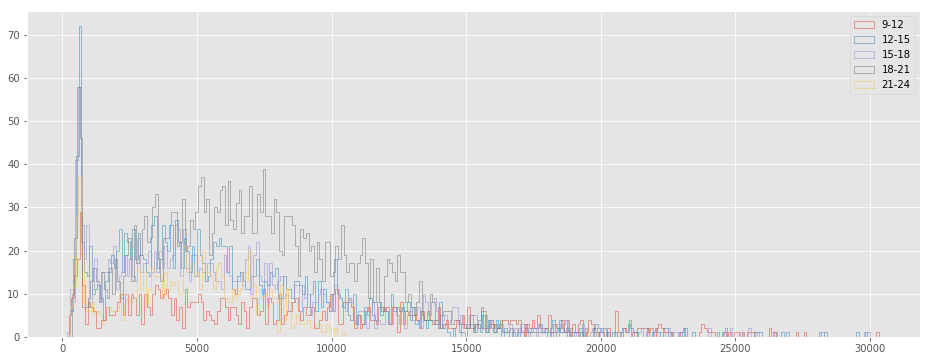

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 100

data = shopper_df[
    (pd.datetime(2016, 12, 22, 9) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 12) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='9-12');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 12) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 15) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='12-15');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 15) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 18) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='15-18');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 18) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 21) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='18-21');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 21) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 23, 0) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='21-24');

ax.legend();

### Initiate the simulation

In [14]:
start_date_time = datetime.datetime(year=2016, month=12, day=22, hour=9)
end_date_time = datetime.datetime(year=2016, month=12, day=23, hour=0)

In [15]:
environment = copy.deepcopy(environment_)

In [16]:
sim = NetworkSimulation(environment, max_shoppers=9000, start_date_time=start_date_time, end_date_time=end_date_time)

### Create the distributions

In [17]:
length_of_stay_distribution = gaussian_kde((shopper_df.length_of_stay / 60).as_matrix())

In [18]:
arrival_distribution = gaussian_kde(
    (pd.to_datetime(shopper_df.start_time) - start_date_time).dt.round('15min').dt.total_seconds().as_matrix()
)

In [19]:
sim.length_of_stay_distribution = length_of_stay_distribution
sim.arrival_distribution = arrival_distribution

## Run the simulation

The simulation requires the maximum number of iterations (time) and the maximum number of shoppers (agents).

In [20]:
sim.iterate(max_iterations=1000)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

## Histograms comparing actual vs simulated shoppers

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


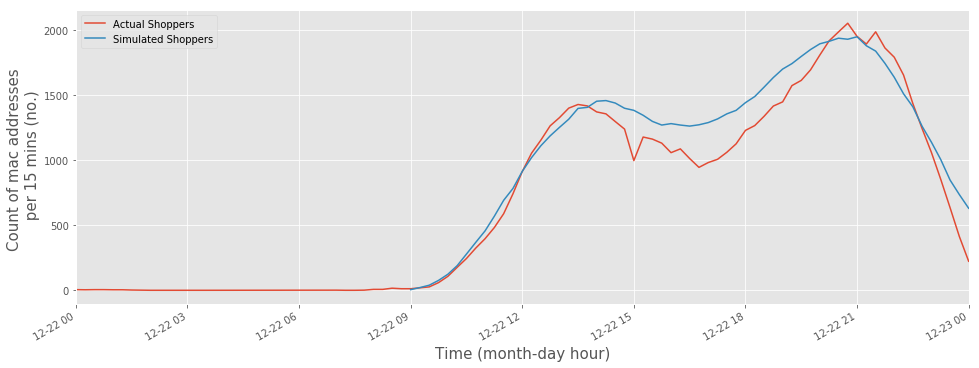

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper_df.mac_address)], 
    axes=ax,
    label='Actual Shoppers',
)

plot_histogram_jn(
    sim.signal_df, 
    axes=ax,
    label='Simulated Shoppers',
);

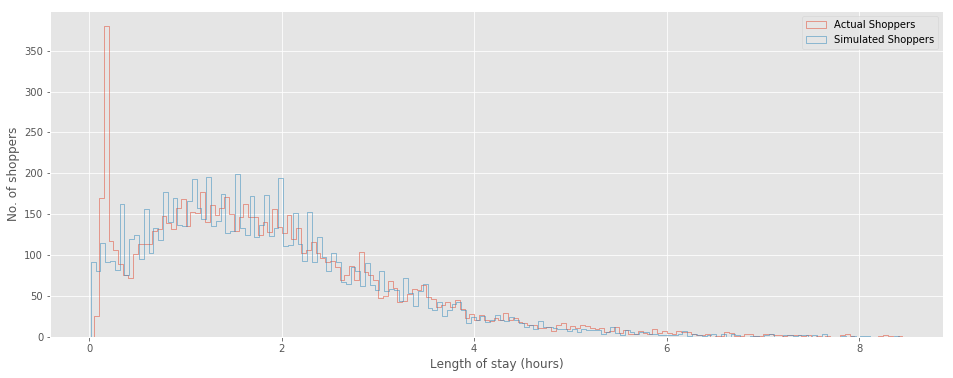

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.05

data = (shopper_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers');

data = (sim.mac_address_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Length of stay (hours)')

ax.legend();

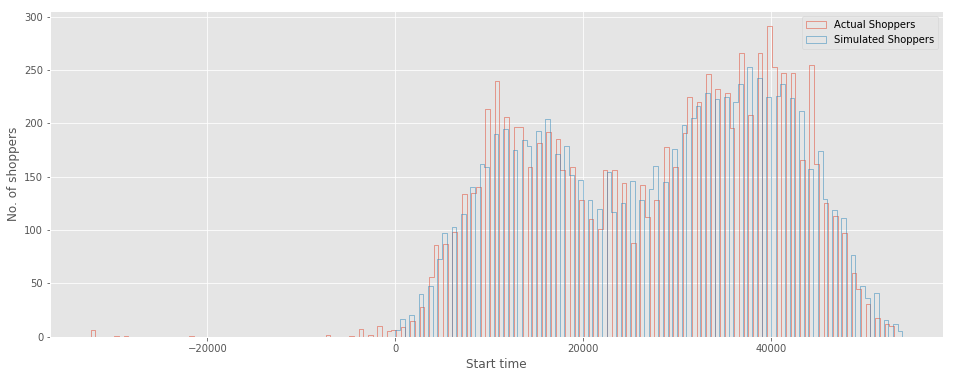

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 500

start_time = min(pd.to_datetime(sim.mac_address_df.start_time))

data = (pd.to_datetime(shopper_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers')


data = (pd.to_datetime(sim.mac_address_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Start time')

ax.legend();

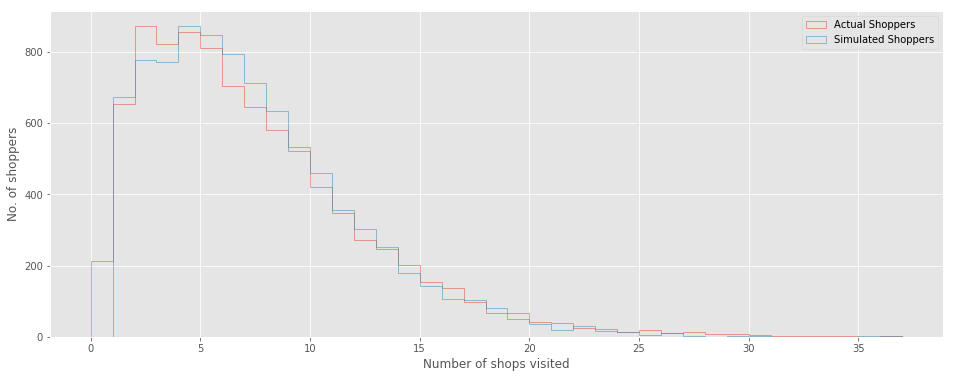

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers')

data = sim.mac_address_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Number of shops visited')

ax.legend();

## Extract features

In [25]:
from msci.cleaning.features import calculate_radius_gyration

In [26]:
sim.mac_address_df['centroid'], sim.mac_address_df['radius_of_gyration'] = \
    calculate_radius_gyration(sim.signal_df, sim.mac_address_df)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8782), HTML(value='')))

In [27]:
r_signal_df = pd.merge(
    signal_df[
        signal_df.store_id.notnull() & 
        (signal_df.store_id.str[0] == 'B') & 
        signal_df.mac_address.isin(shopper_df.mac_address)
    ], 
    shop_df[['store_id', 'x', 'y']], 
    on='store_id', 
    how='left',
    suffixes=('_actual', '')
)

r_shopper_df = shopper_df[shopper_df.mac_address.isin(r_signal_df.mac_address)]

In [28]:
r_shopper_df['centroid'], r_shopper_df['radius_of_gyration'] = \
    calculate_radius_gyration(r_signal_df, r_shopper_df)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8714), HTML(value='')))

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
def probability_of_moving_forwards(signal_df, mac_address_df):
    signal_sorted_df = signal_df.sort_values('date_time')
    signal_mac_group = signal_sorted_df.groupby('mac_address')
    macs = mac_address_df.mac_address.tolist()
    probabilities = []
    for mac in tqdm(range(len(macs)), desc='Radius of Gyration'):
        prob = np.nan
        r = signal_mac_group.get_group(macs[mac])[['x', 'y']].as_matrix()
        if len(r) > 2:
            direction = r[1:] - r[:-1]
            direction = direction[np.any(direction != 0, axis=1)]
            if len(direction) > 1:
                r1r2 = np.array([np.dot(i, j) for i, j in zip(direction[1:], direction[:-1])])
                prob = len(np.where(r1r2 > 0)[0]) / len(r1r2)
        probabilities.append(prob)
    return probabilities

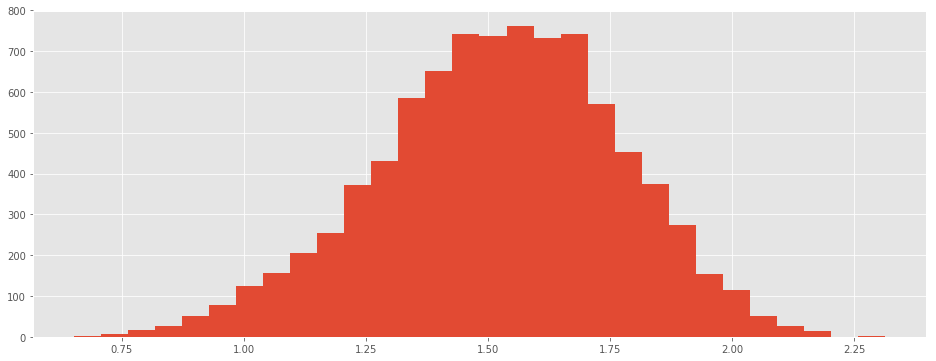

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
r_shopper_df['av_turning_angle'].hist(bins=30)

In [33]:
r_shopper_df['prob_forwards'] = probability_of_moving_forwards(r_signal_df, r_shopper_df)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8714), HTML(value='')))

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
sim.mac_address_df['prob_forwards'] = probability_of_moving_forwards(sim.signal_df, sim.mac_address_df)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8782), HTML(value='')))

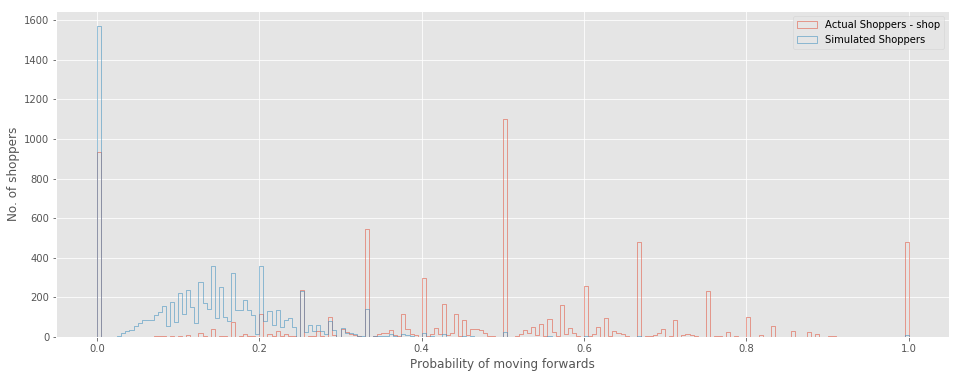

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.005

data = r_shopper_df[r_shopper_df.prob_forwards.notnull()].prob_forwards.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.prob_forwards.notnull()].prob_forwards.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Probability of moving forwards')

ax.legend();

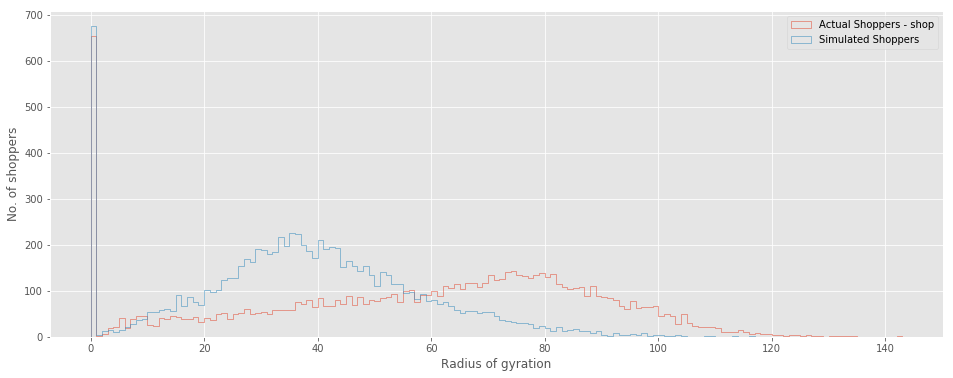

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = r_shopper_df.radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

# data = shopper_df.radius_of_gyration.as_matrix()
# ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers')

data = sim.mac_address_df.radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Radius of gyration')

ax.legend();

In [41]:
def add_count_of_shoppers(signal_df, shop_df):
    count_of_shoppers = []
    signal_group = signal_df.groupby('store_id')
    for shop in tqdm(shop_df.store_id.tolist(), desc='Count of shoppers'):
        group = signal_group.get_group(shop)
        count_of_shoppers.append(len(group.mac_address.unique()))
    return count_of_shoppers

In [42]:
shop_df['sim_count'] = add_count_of_shoppers(sim.signal_df, shop_df)
shop_df['act_count'] = add_count_of_shoppers(signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

In [43]:
from scipy.stats import linregress

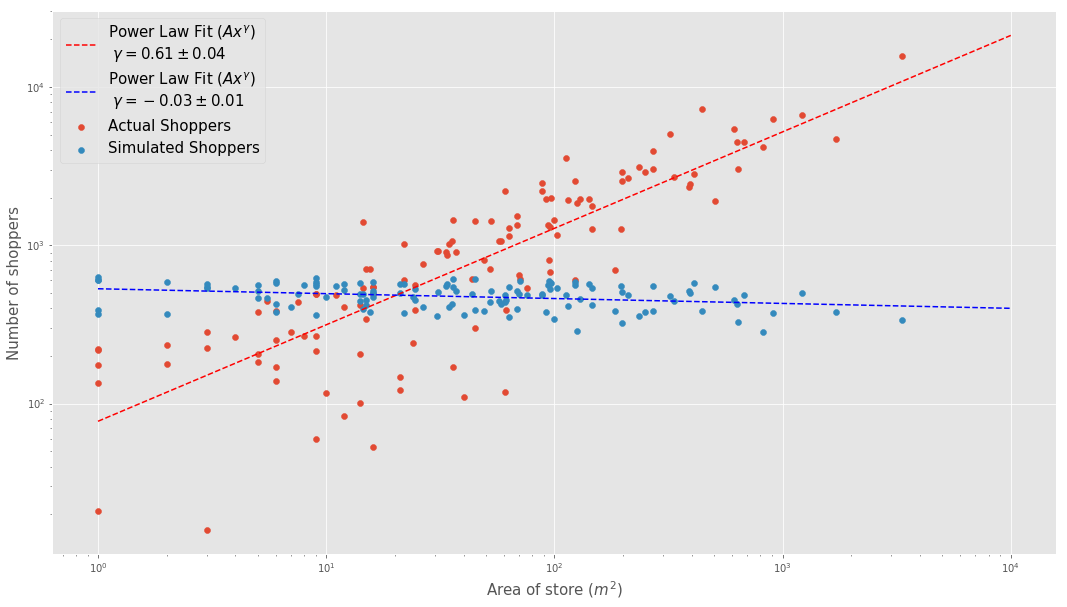

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

area_shop_df = shop_df[(shop_df.area > 0) & (shop_df.act_count > 0) & (shop_df.sim_count > 0)]

ax.scatter(area_shop_df.area, area_shop_df.act_count, label='Actual Shoppers')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.act_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'r--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.scatter(area_shop_df.area, area_shop_df.sim_count, label='Simulated Shoppers')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.sim_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'b--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Number of shoppers', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=15);